# Cleaning data obtained from the API

In [1]:
import pandas as pd
from glob import glob
from datetime import date
import matplotlib.pyplot as pl
import json

import xavy.explore as xe
import xavy.dataframes as xd

import modules.w3c_api as wa

## Functions

In [2]:
def std2json(string):
    """
    Parse a string representing into a JSON data.
    """
    std_str = string.replace('"', r'\"').replace("'", '"').replace('False', 'false').replace('True', 'true')
    data = json.loads(std_str)
    return data

## W3C Groups

In [3]:
# Load data:
group_list_df = wa.load_raw_api_data('../data/raw/api/w3c_groups_list_2024-07-25.csv')
groups_df = wa.load_raw_api_data('../data/raw/api/w3c_groups_properties_2024-07-25.csv')

# Se tudo passar, grupos nas duas tabelas são os mesmos e são identificados por nome e endpoint:
assert len(group_list_df) == len(groups_df)
assert set(groups_df['name']) == set(group_list_df['title'])
assert set(groups_df['call']) == set(group_list_df['href'])
assert xd.iskeyQ(group_list_df[['href']])
assert xd.iskeyQ(group_list_df[['title']])
assert xd.iskeyQ(groups_df[['call']])
assert xd.iskeyQ(groups_df[['name']])

# Remove unnecessary df:
del group_list_df

**About the data**
* Data only include currently active groups (i.e. open).
* Short names are not unique, there are community, interest and working groups with the same short name.
* Apparently the only external groups are Task Forces.
* Task Forces are the only groups that do not have a homepage.
* Task Forces are subordinated to other groups, and any king of group can have task forces.
* Community groups might publish specifications or not.
* The 'spec-publisher' column only deals with community and business groups.

### Explore the data

#### General trends

In [4]:
# Verify missing values:
groups_df.isnull().mean().sort_values()

id                          0.000000
chairs                      0.000000
discr                       0.000000
shortname                   0.000000
call                        0.000000
is_closed                   0.000000
name                        0.000000
users                       0.004016
description                 0.044177
homepage                    0.096386
type                        0.216867
participations              0.224900
spec-publisher              0.425703
start-date                  0.791165
end-date                    0.791165
members                     0.799197
internal                    0.799197
participants_list_public    0.799197
dtype: float64

#### Names and identifiers

In [103]:
# Group ID is primary key:
assert xd.iskeyQ(groups_df[['id']])
# Description is unique IF existant:
assert xd.iskeyQ(groups_df[['description']].dropna())

In [104]:
# Short names shared by community, interest, and working groups:
xd.print_array_series(xd.check_guarda_compartilhada(groups_df, 'shortname', 'name'))

gpu: GPU for the Web Community Group / GPU for the Web Working Group
immersive-web: Immersive Web Community Group / Immersive Web Working Group
json-ld: JSON for Linking Data Community Group / JSON-LD Working Group
miniapps: MiniApps Ecosystem Community Group / MiniApps Working Group
webmachinelearning: Web Machine Learning Community Group / Web Machine Learning Working Group
wot: Web of Things Community Group / Web of Things Interest Group / Web of Things Working Group


#### Constant columns

In [105]:
# Check if all groups are open (i.e. currently running):
groups_df['is_closed'].value_counts(normalize=True)

False    1.0
Name: is_closed, dtype: float64

#### Types of groups

In [106]:
groups_df['discr'].value_counts(dropna=False)

w3cgroup    195
tf           50
group         4
Name: discr, dtype: int64

In [107]:
# The groups 'discr' as 'group' are four top-level groups:
groups_df.loc[groups_df['discr'] == 'group']

,id,name,is_closed,description,shortname,spec-publisher,discr,type,call,homepage,users,participations,chairs,members,internal,participants_list_public,start-date,end-date
11,7756,Advisory Board,False,"The <a href=""https://www.w3.org/Consortium/Pro...",ab,NaN,group,NaN,https://api.w3.org/groups/other/ab,https://www.w3.org/Member/Board/,https://api.w3.org/groups/other/ab/users,NaN,https://api.w3.org/groups/other/ab/chairs,NaN,NaN,NaN,NaN,NaN
13,33280,Advisory Committee,False,The Advisory Committee represents the <a href=...,ac,NaN,group,NaN,https://api.w3.org/groups/other/ac,https://www.w3.org/groups/other/ac/,NaN,NaN,https://api.w3.org/groups/other/ac/chairs,NaN,NaN,NaN,NaN,NaN
39,140563,Board of Directors,False,"<p>The W3C Board of Directors —first <a href=""...",board,NaN,group,NaN,https://api.w3.org/groups/other/board,https://www.w3.org/groups/other/board/,https://api.w3.org/groups/other/board/users,NaN,https://api.w3.org/groups/other/board/chairs,NaN,NaN,NaN,NaN,NaN
194,34270,Technical Architecture Group,False,<p>The TAG is a special working group within t...,tag,NaN,group,NaN,https://api.w3.org/groups/other/tag,https://www.w3.org/2001/tag/,https://api.w3.org/groups/other/tag/users,NaN,https://api.w3.org/groups/other/tag/chairs,NaN,NaN,NaN,NaN,NaN


In [108]:
# Groups 'discr' as 'tf' are diverse: 
groups_df.query('discr == "tf"').sample(4)

,id,name,is_closed,description,shortname,spec-publisher,discr,type,call,homepage,users,participations,chairs,members,internal,participants_list_public,start-date,end-date
1,93339,Accessibility Conformance Testing (ACT) Task F...,False,The objective of the Accessibility Conformance...,wcag-act,NaN,tf,NaN,https://api.w3.org/groups/tf/wcag-act,https://www.w3.org/WAI/GL/task-forces/conforma...,https://api.w3.org/groups/tf/wcag-act/users,NaN,https://api.w3.org/groups/tf/wcag-act/chairs,"[{'id': 35422, 'name': 'Accessibility Guidelin...",False,True,NaN,NaN
149,139586,RDF Dataset Canonicalization and Hash Working ...,False,NaN,rch-wg-chairs,NaN,tf,NaN,https://api.w3.org/groups/tf/rch-wg-chairs,NaN,https://api.w3.org/groups/tf/rch-wg-chairs/users,NaN,https://api.w3.org/groups/tf/rch-wg-chairs/chairs,"[{'id': 138751, 'name': 'RDF Dataset Canonical...",False,False,NaN,NaN
209,101569,WAI Adapt Task Force,False,The Personalization Task Force changed its nam...,personalization-tf,NaN,tf,NaN,https://api.w3.org/groups/tf/personalization-tf,https://www.w3.org/WAI/APA/task-forces/adapt/,https://api.w3.org/groups/tf/personalization-t...,NaN,https://api.w3.org/groups/tf/personalization-t...,"[{'id': 83907, 'name': 'Accessible Platform Ar...",False,True,NaN,NaN
182,106744,Southeast Asian Layout Task Force,False,This task force explores gaps in Southeast Asi...,i18n-sealreq,NaN,tf,NaN,https://api.w3.org/groups/tf/i18n-sealreq,https://github.com/w3c/sealreq/,https://api.w3.org/groups/tf/i18n-sealreq/users,NaN,https://api.w3.org/groups/tf/i18n-sealreq/chairs,"[{'id': 72665, 'name': 'Internationalization I...",False,True,NaN,NaN


In [109]:
groups_df['type'].value_counts(dropna=False)

community group    141
NaN                 54
working group       43
interest group       9
business group       2
Name: type, dtype: int64

In [110]:
# discr 'w3cgroup' are the groups with a given type
print(xe.bold('discr') + ' subclasses')
xd.print_array_series(xd.check_guarda_compartilhada(groups_df.fillna('NULO'), 'discr', 'type', drop_unique=False))

#print('')
#print(xe.bold('type') + ' subclasses')
#xd.print_array_series(xd.check_guarda_compartilhada(groups_df.fillna('NULO'), 'type', 'discr', drop_unique=False))

discr subclasses
group: NULO
tf: NULO
w3cgroup: community group / working group / interest group / business group


Apparently the only external groups are Task Forces:

In [111]:
groups_df['internal'].value_counts(dropna=False)

NaN      199
False     50
Name: internal, dtype: int64

In [112]:
xd.check_guarda_compartilhada(groups_df, 'discr', 'internal', drop_unique=False)

discr
group         [nan]
tf          [False]
w3cgroup      [nan]
Name: internal, dtype: object

#### Properties of groups

In [113]:
#xe.mapUnique(groups_df.loc[groups_df['homepage'].isnull()])

Does the group publishes specifications?

In [114]:
groups_df['spec-publisher'].value_counts(dropna=False)

True     126
NaN      106
False     17
Name: spec-publisher, dtype: int64

In [115]:
xd.check_guarda_compartilhada(groups_df, 'discr', 'spec-publisher', drop_unique=False)

discr
group                    [nan]
tf                       [nan]
w3cgroup    [True, nan, False]
Name: spec-publisher, dtype: object

In [116]:
xd.check_guarda_compartilhada(groups_df, 'type', 'spec-publisher', drop_unique=False)

type
business group            [True]
community group    [True, False]
interest group             [nan]
working group              [nan]
Name: spec-publisher, dtype: object

In [117]:
# All groups without homepages are task forces:
groups_df.loc[groups_df['homepage'].isnull(), 'discr'].value_counts()

tf    24
Name: discr, dtype: int64

In [118]:
# Only the AC has no public list of users (only accessible with W3C member credentials) 
groups_df.loc[groups_df['users'].isnull()]

,id,name,is_closed,description,shortname,spec-publisher,discr,type,call,homepage,users,participations,chairs,members,internal,participants_list_public,start-date,end-date
13,33280,Advisory Committee,False,The Advisory Committee represents the <a href=...,ac,NaN,group,NaN,https://api.w3.org/groups/other/ac,https://www.w3.org/groups/other/ac/,NaN,NaN,https://api.w3.org/groups/other/ac/chairs,NaN,NaN,NaN,NaN,NaN


Is the list of participants public?

In [119]:
# How many in each situation:
groups_df['participants_list_public'].value_counts(dropna=False)

NaN      199
True      45
False      5
Name: participants_list_public, dtype: int64

In [120]:
# Groups with information about the publicity of list of participants:
pl_groups_df = groups_df.loc[~groups_df['participants_list_public'].isnull()]
pl_groups_df['discr'].value_counts(dropna=False)
# Only Task Forces.

tf    50
Name: discr, dtype: int64

In [121]:
# Groups with no information about the publicity of list of participants:
npl_groups_df = groups_df.loc[groups_df['participants_list_public'].isnull()]
npl_groups_df['discr'].value_counts(dropna=False)
# No Task Forces.

w3cgroup    195
group         4
Name: discr, dtype: int64

In [122]:
# List of participants is not public:
groups_df.loc[groups_df['participants_list_public'] == False]

,id,name,is_closed,description,shortname,spec-publisher,discr,type,call,homepage,users,participations,chairs,members,internal,participants_list_public,start-date,end-date
45,156120,"Chairs of the Board, AB, and TAG",False,NaN,board-ab-tag-chairs,NaN,tf,NaN,https://api.w3.org/groups/tf/board-ab-tag-chairs,NaN,https://api.w3.org/groups/tf/board-ab-tag-chai...,NaN,https://api.w3.org/groups/tf/board-ab-tag-chai...,[],False,False,NaN,NaN
149,139586,RDF Dataset Canonicalization and Hash Working ...,False,NaN,rch-wg-chairs,NaN,tf,NaN,https://api.w3.org/groups/tf/rch-wg-chairs,NaN,https://api.w3.org/groups/tf/rch-wg-chairs/users,NaN,https://api.w3.org/groups/tf/rch-wg-chairs/chairs,"[{'id': 138751, 'name': 'RDF Dataset Canonical...",False,False,NaN,NaN
159,143171,RDF-star WG chairs,False,NaN,rdf-star-chairs,NaN,tf,NaN,https://api.w3.org/groups/tf/rdf-star-chairs,NaN,https://api.w3.org/groups/tf/rdf-star-chairs/u...,NaN,https://api.w3.org/groups/tf/rdf-star-chairs/c...,"[{'id': 139681, 'name': 'RDF-star Working Grou...",False,False,NaN,NaN
200,121208,Transportation Ontology Coordination Committee,False,NaN,transportation-ont-cc,NaN,tf,NaN,https://api.w3.org/groups/tf/transportation-on...,NaN,https://api.w3.org/groups/tf/transportation-on...,NaN,https://api.w3.org/groups/tf/transportation-on...,"[{'id': 61259, 'name': 'Automotive and Transpo...",False,False,NaN,NaN
205,133097,Verifiable Credentials Working Group Chairs,False,NaN,vc-wg-chairs,NaN,tf,NaN,https://api.w3.org/groups/tf/vc-wg-chairs,NaN,https://api.w3.org/groups/tf/vc-wg-chairs/users,NaN,https://api.w3.org/groups/tf/vc-wg-chairs/chairs,"[{'id': 98922, 'name': 'Verifiable Credentials...",False,False,NaN,NaN


In [123]:
# List of participants is not public:
groups_df.loc[groups_df['participants_list_public'] == True]

,id,name,is_closed,description,shortname,spec-publisher,discr,type,call,homepage,users,participations,chairs,members,internal,participants_list_public,start-date,end-date
1,93339,Accessibility Conformance Testing (ACT) Task F...,False,The objective of the Accessibility Conformance...,wcag-act,NaN,tf,NaN,https://api.w3.org/groups/tf/wcag-act,https://www.w3.org/WAI/GL/task-forces/conforma...,https://api.w3.org/groups/tf/wcag-act/users,NaN,https://api.w3.org/groups/tf/wcag-act/chairs,"[{'id': 35422, 'name': 'Accessibility Guidelin...",False,True,NaN,NaN
12,147348,Advisory Board Elected Members,False,Elected members of the Advisory Board,ab-elected,NaN,tf,NaN,https://api.w3.org/groups/tf/ab-elected,NaN,https://api.w3.org/groups/tf/ab-elected/users,NaN,https://api.w3.org/groups/tf/ab-elected/chairs,"[{'id': 7756, 'name': 'Advisory Board', 'is_cl...",False,True,NaN,NaN
14,113779,African Layout Task Force,False,This task force explores gaps in African langu...,i18n-afrlreq,NaN,tf,NaN,https://api.w3.org/groups/tf/i18n-afrlreq,https://github.com/w3c/afrlreq/,https://api.w3.org/groups/tf/i18n-afrlreq/users,NaN,https://api.w3.org/groups/tf/i18n-afrlreq/chairs,"[{'id': 72665, 'name': 'Internationalization I...",False,True,NaN,NaN
17,81089,Arabic Layout Task Force,False,This task force explores gaps in Arabic and Pe...,i18n-alreq,NaN,tf,NaN,https://api.w3.org/groups/tf/i18n-alreq,https://github.com/w3c/alreq/,https://api.w3.org/groups/tf/i18n-alreq/users,NaN,https://api.w3.org/groups/tf/i18n-alreq/chairs,"[{'id': 72665, 'name': 'Internationalization I...",False,True,NaN,NaN
19,102172,ARIA Authoring Practices Task Force,False,The ARIA Authoring Practices task force to dev...,aria-practices,NaN,tf,NaN,https://api.w3.org/groups/tf/aria-practices,https://www.w3.org/WAI/ARIA/task-forces/practi...,https://api.w3.org/groups/tf/aria-practices/users,NaN,https://api.w3.org/groups/tf/aria-practices/ch...,"[{'id': 83726, 'name': 'Accessible Rich Intern...",False,True,NaN,NaN
20,140270,ARIA Editors,False,Coordination for editors of ARIA specifications,aria-editors,NaN,tf,NaN,https://api.w3.org/groups/tf/aria-editors,https://www.w3.org/WAI/ARIA/editors/,https://api.w3.org/groups/tf/aria-editors/users,NaN,https://api.w3.org/groups/tf/aria-editors/chairs,"[{'id': 83726, 'name': 'Accessible Rich Intern...",False,True,NaN,NaN
26,101081,Automotive Payments Task Force,False,NaN,automotive-pay,NaN,tf,NaN,https://api.w3.org/groups/tf/automotive-pay,NaN,https://api.w3.org/groups/tf/automotive-pay/users,NaN,https://api.w3.org/groups/tf/automotive-pay/ch...,"[{'id': 61259, 'name': 'Automotive and Transpo...",False,True,NaN,NaN
27,78932,Automotive Privacy and Security Task Force,False,NaN,auto-privacy-security,NaN,tf,NaN,https://api.w3.org/groups/tf/auto-privacy-secu...,NaN,https://api.w3.org/groups/tf/auto-privacy-secu...,NaN,https://api.w3.org/groups/tf/auto-privacy-secu...,"[{'id': 61259, 'name': 'Automotive and Transpo...",False,True,NaN,NaN
33,149084,Board Audit Committee,False,"<p> In accordance with the <a href=""https://ww...",board-audit,NaN,tf,NaN,https://api.w3.org/groups/tf/board-audit,NaN,https://api.w3.org/groups/tf/board-audit/users,NaN,https://api.w3.org/groups/tf/board-audit/chairs,"[{'id': 140563, 'name': 'Board of Directors', ...",False,True,NaN,NaN
34,152308,Board Development Committee,False,<p>The Board Development Committee enables the...,board-development,NaN,tf,NaN,https://api.w3.org/groups/tf/board-development,NaN,https://api.w3.org/groups/tf/board-development...,NaN,https://api.w3.org/groups/tf/board-development...,"[{'id': 140563, 'name': 'Board of Directors', ...",False,True,NaN,NaN


#### Participations

In [124]:
# Only the AC has no public list of users (only accessible with W3C member credentials) 
xd.print_string_series(groups_df.loc[~groups_df['participations'].isnull()].set_index('name')['participations'])

Accessibility at the Edge Community Group: https://api.w3.org/groups/cg/a11yedge/participations
Accessibility Discoverability Vocabulary for Schema.org Community Group: https://api.w3.org/groups/cg/a11y-discov-vocab/participations
Accessibility Education and Outreach Working Group (EOWG): https://api.w3.org/groups/wg/eowg/participations
Accessibility for Children Community Group: https://api.w3.org/groups/cg/accessibility4children/participations
Accessibility Guidelines Working Group: https://api.w3.org/groups/wg/ag/participations
Accessibility Internationalization Community Group: https://api.w3.org/groups/cg/global-inclusion/participations
Accessible Platform Architectures Working Group: https://api.w3.org/groups/wg/apa/participations
Accessible Rich Internet Applications Working Group: https://api.w3.org/groups/wg/aria/participations
ACT Rules Community Group: https://api.w3.org/groups/cg/act-r/participations
Advancing Accessibility Resources Community Group: https://api.w3.org/grou

#### Members

**Conclusion:** The 'members' column is meant to show to what Groups the Task Forces are associated. 

In [125]:
# Tipos de grupos sem informação de membros:
groups_df.loc[groups_df['members'].isnull(), 'discr'].value_counts(dropna=False)

w3cgroup    195
group         4
Name: discr, dtype: int64

In [126]:
# Tipos de grupos com informação de membros:
w_members_df = groups_df.loc[~groups_df['members'].isnull()]
w_members_df['discr'].value_counts(dropna=False)

tf    50
Name: discr, dtype: int64

In [129]:
# To how many groups are the TFs associated to:
tf_members = w_members_df['members']
tf_members_data = tf_members.apply(lambda s: std2json(s))
tf_members_data.str.len().value_counts()

1    41
2     6
3     2
0     1
Name: members, dtype: int64

In [130]:
# Exception: O TF group of all chairs:
w_members_df.loc[tf_members_data.str.len() == 0]

,id,name,is_closed,description,shortname,spec-publisher,discr,type,call,homepage,users,participations,chairs,members,internal,participants_list_public,start-date,end-date
45,156120,"Chairs of the Board, AB, and TAG",False,NaN,board-ab-tag-chairs,NaN,tf,NaN,https://api.w3.org/groups/tf/board-ab-tag-chairs,NaN,https://api.w3.org/groups/tf/board-ab-tag-chai...,NaN,https://api.w3.org/groups/tf/board-ab-tag-chai...,[],False,False,NaN,NaN


In [131]:
# Number of Task Forces per Group ID:
n_tf_per_group = tf_members_data.apply(lambda l: [d['id'] for d in l]).explode().dropna().value_counts()
n_tf_per_group

72665     11
140563     8
35422      7
83907      6
139681     4
61259      3
83726      3
7756       2
144835     2
76043      2
152307     1
149106     1
99375      1
73816      1
34270      1
97159      1
110591     1
138751     1
19480      1
102593     1
98922      1
Name: members, dtype: int64

In [132]:
# Any type of group can have Task Forces:
groups_df.loc[groups_df['id'].isin(n_tf_per_group.index)]

,id,name,is_closed,description,shortname,spec-publisher,discr,type,call,homepage,users,participations,chairs,members,internal,participants_list_public,start-date,end-date
5,35422,Accessibility Guidelines Working Group,False,The mission of the Accessibility Guidelines Wo...,ag,NaN,w3cgroup,working group,https://api.w3.org/groups/wg/ag,https://www.w3.org/WAI/GL/,https://api.w3.org/groups/wg/ag/users,https://api.w3.org/groups/wg/ag/participations,https://api.w3.org/groups/wg/ag/chairs,NaN,NaN,NaN,1997-10-06,2025-10-31
7,83907,Accessible Platform Architectures Working Group,False,The mission of the Accessible Platform Archite...,apa,NaN,w3cgroup,working group,https://api.w3.org/groups/wg/apa,https://www.w3.org/WAI/APA/,https://api.w3.org/groups/wg/apa/users,https://api.w3.org/groups/wg/apa/participations,https://api.w3.org/groups/wg/apa/chairs,NaN,NaN,NaN,2015-10-22,2025-07-31
8,83726,Accessible Rich Internet Applications Working ...,False,The mission of the Accessible Rich Internet Ap...,aria,NaN,w3cgroup,working group,https://api.w3.org/groups/wg/aria,https://www.w3.org/WAI/ARIA/,https://api.w3.org/groups/wg/aria/users,https://api.w3.org/groups/wg/aria/participations,https://api.w3.org/groups/wg/aria/chairs,NaN,NaN,NaN,2015-10-22,2024-12-31
11,7756,Advisory Board,False,"The <a href=""https://www.w3.org/Consortium/Pro...",ab,NaN,group,NaN,https://api.w3.org/groups/other/ab,https://www.w3.org/Member/Board/,https://api.w3.org/groups/other/ab/users,NaN,https://api.w3.org/groups/other/ab/chairs,NaN,NaN,NaN,NaN,NaN
39,140563,Board of Directors,False,"<p>The W3C Board of Directors —first <a href=""...",board,NaN,group,NaN,https://api.w3.org/groups/other/board,https://www.w3.org/groups/other/board/,https://api.w3.org/groups/other/board/users,NaN,https://api.w3.org/groups/other/board/chairs,NaN,NaN,NaN,NaN,NaN
64,99375,Dataset Exchange Working Group,False,The mission of the Dataset Exchange WG is to:\...,dx,NaN,w3cgroup,working group,https://api.w3.org/groups/wg/dx,https://www.w3.org/2017/dxwg/,https://api.w3.org/groups/wg/dx/users,https://api.w3.org/groups/wg/dx/participations,https://api.w3.org/groups/wg/dx/chairs,NaN,NaN,NaN,2017-05-05,2024-12-31
99,72665,Internationalization Interest Group,False,The mission of the Internationalization (I18n)...,i18n,NaN,w3cgroup,interest group,https://api.w3.org/groups/ig/i18n,https://www.w3.org/International/ig/,https://api.w3.org/groups/ig/i18n/users,NaN,https://api.w3.org/groups/ig/i18n/chairs,NaN,NaN,NaN,1998-02-12,2024-09-30
144,97159,Publishing Business Group,False,<p>The Publishing Business Group fosters ongoi...,publishingbg,True,w3cgroup,business group,https://api.w3.org/groups/bg/publishingbg,https://www.w3.org/community/publishingbg/,https://api.w3.org/groups/bg/publishingbg/users,https://api.w3.org/groups/bg/publishingbg/part...,https://api.w3.org/groups/bg/publishingbg/chairs,NaN,NaN,NaN,NaN,NaN
145,110591,Publishing Community Group,False,Incubation zone for Publishing@W3C. Bring your...,publishingcg,True,w3cgroup,community group,https://api.w3.org/groups/cg/publishingcg,https://www.w3.org/community/publishingcg/,https://api.w3.org/groups/cg/publishingcg/users,https://api.w3.org/groups/cg/publishingcg/part...,https://api.w3.org/groups/cg/publishingcg/chairs,NaN,NaN,NaN,NaN,NaN
146,144835,Publishing Maintenance Working Group,False,The mission of the Publishing Maintenance Work...,pm,NaN,w3cgroup,working group,https://api.w3.org/groups/wg/pm,https://www.w3.org/groups/wg/pm/,https://api.w3.org/groups/wg/pm/users,https://api.w3.org/groups/wg/pm/participations,https://api.w3.org/groups/wg/pm/chairs,NaN,NaN,NaN,2023-06-20,2025-06-30


### Selecting relevant data

#### Ignoring Task Forces

[Task Forces](https://www.w3.org/policies/process/#ReqsAllGroups) are subordinated to the other groups, 
so we will ignore them in our group analysis and will also ignore the information that is only associated to them, and uninformative columns (e.g. 'is_closed').

In [5]:
# Remove Task Forces:
no_tfs_df = groups_df.loc[groups_df['discr'] != 'tf']
# Drop empty and constant columns:
no_tfs_df = xd.split_constant_cols(no_tfs_df)

# Groups with no type are permanent groups:
assert set(no_tfs_df.loc[no_tfs_df['type'].isnull(), 'name']) == {'Advisory Board', 'Advisory Committee', 'Board of Directors', 'Technical Architecture Group'}
no_tfs_df['type'].fillna('permanent group', inplace=True)

# Groups 'discr == group' are all permanent groups, so the discr column in unnecessary:
assert set(no_tfs_df.loc[no_tfs_df['discr'] == 'group', 'type']) == {'permanent group'}
no_tfs_df.drop('discr', axis=1, inplace=True)

In [6]:
# Save to CSV:
today = date.today().strftime('%Y-%m-%d')
#no_tfs_df.to_csv('../data/processed/w3c_groups_properties_{:}_no-tfs.csv'.format(today), index=False)

## Group participants

In [8]:
# Load raw data about group participants:
group_participants_df = wa.load_raw_api_data('../data/raw/api/w3c_participants_group-*_2024-07-25.csv')
# Drop uninformative columns ('former' is always False):
group_participants_df = xd.split_constant_cols(group_participants_df)

Attention: there are different people with the same name. Use the URLs under 'href' as identifiers.

In [19]:
# Save data:
# group_participants_df[['call','title','href']].to_csv('../data/processed/w3c_groups_participants_2024-07-25.csv', index=False

## Affiliations

In [21]:
# Load raw data about participants' affiliations:
affiliations_df = wa.load_raw_api_data('../data/raw/api/w3c_affiliations_batch-*_2024-07-25.csv')

In [24]:
# Save the data:
#affiliations_df[['call', 'title', 'href']].to_csv('../data/processed/w3c_participants_affiliations_2024-07-25.csv', index=False)

## Organizations' details

In [25]:
# Load raw data about participants' affiliations:
orgs_df = wa.load_raw_api_data('../data/raw/api/w3c_organizations_batch-*_2024-07-26.csv')

### Exploration

**Conclusions**
* Apart from testimonials, the only missing information are membership characteristics of W3C and W3C invited experts.
* The only affiliations are W3C and W3C invited experts. The others are organizations.
* The column 'is-partner-member' is always false, except for W3C and W3C invited experts, for which are NaNs. 

#### Basic

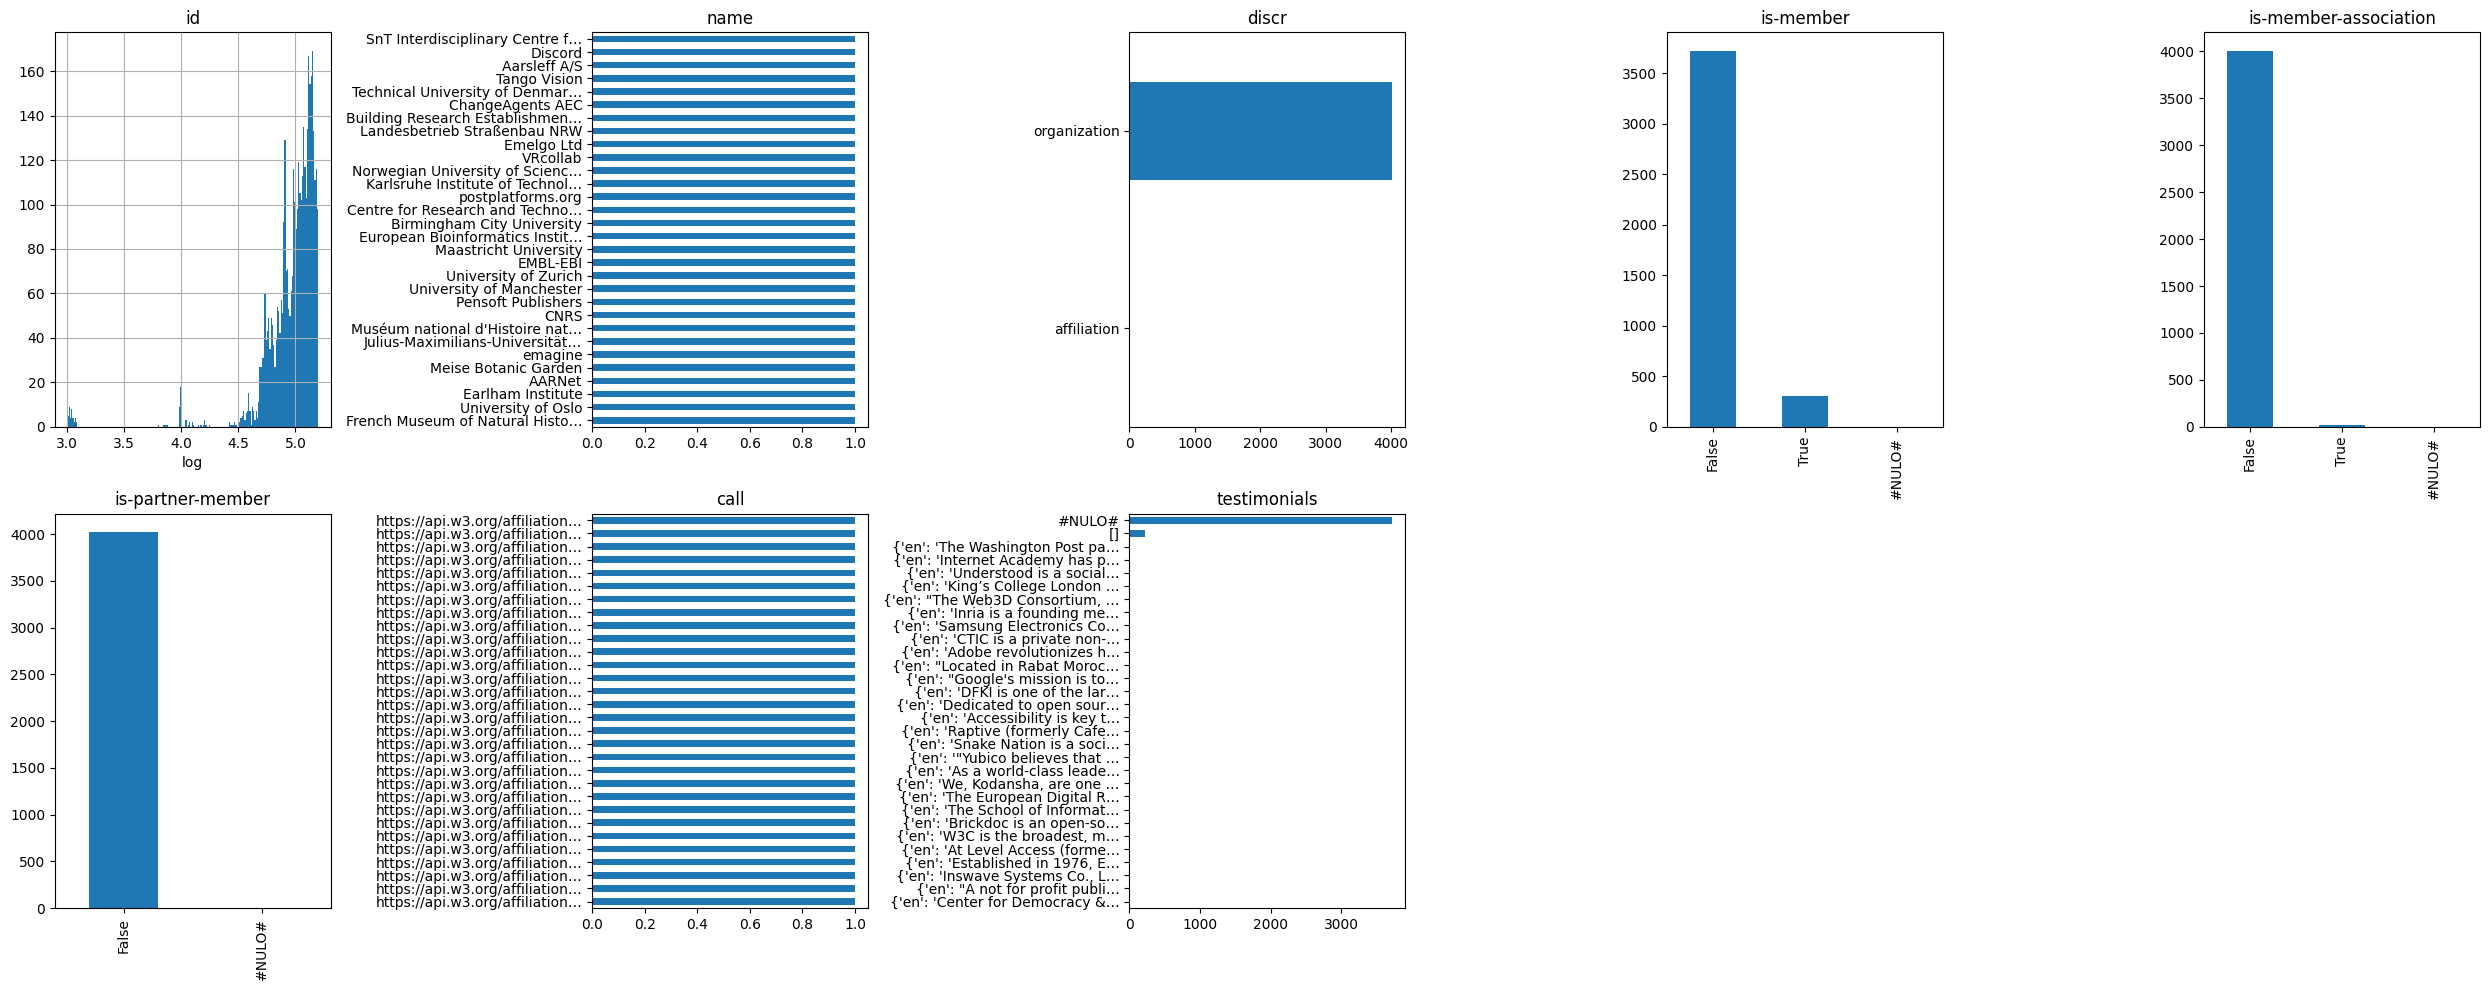

In [30]:
xe.multiple_dist_plots(orgs_df.fillna('#NULO#'))

In [27]:
xe.checkMissing(orgs_df)

Colunas com valores faltantes:
                  coluna       N      %
3              is-member     2.0   0.05
4  is-member-association     2.0   0.05
5      is-partner-member     2.0   0.05
7           testimonials  3719.0  92.49


#### Missing values

In [34]:
# The only organizations without membership info is W3C and its invited experts:
orgs_df.loc[orgs_df['is-member'].isnull()]

,id,name,discr,is-member,is-member-association,is-partner-member,call,testimonials
1175,52794,W3C,affiliation,NaN,NaN,NaN,https://api.w3.org/affiliations/52794,NaN
2544,36747,W3C Invited Experts,affiliation,NaN,NaN,NaN,https://api.w3.org/affiliations/36747,NaN


#### Associations between categories

In [38]:
# The only affiliations are W3C and W3C invited experts:
orgs_df.loc[orgs_df['discr'] == 'affiliation']

,id,name,discr,is-member,is-member-association,is-partner-member,call,testimonials
1175,52794,W3C,affiliation,NaN,NaN,NaN,https://api.w3.org/affiliations/52794,NaN
2544,36747,W3C Invited Experts,affiliation,NaN,NaN,NaN,https://api.w3.org/affiliations/36747,NaN


In [33]:
xe.map_subcategories(orgs_df.drop(['id', 'name', 'testimonials', 'call'], axis=1))

Macro-categoria           --> Sub-categoria
is-partner-member         --> discr
discr                     --> is-member
is-partner-member         --> is-member
discr                     --> is-member-association
is-partner-member         --> is-member-association
discr                     --> is-partner-member


In [35]:
xd.check_guarda_compartilhada(orgs_df, 'discr', 'is-partner-member', drop_unique=False)

discr
affiliation       [nan]
organization    [False]
Name: is-partner-member, dtype: object

In [37]:
xd.check_guarda_compartilhada(orgs_df, 'discr', 'is-member', drop_unique=False)

discr
affiliation             [nan]
organization    [False, True]
Name: is-member, dtype: object

#### Member associations

In [39]:
orgs_df.loc[orgs_df['is-member-association'] == True]

,id,name,discr,is-member,is-member-association,is-partner-member,call,testimonials
384,39381,Open Geospatial Consortium,organization,True,True,False,https://api.w3.org/affiliations/39381,"{'en': ""With location at the heart of every de..."
1302,140697,Centre For Accessibility Australia,organization,True,True,False,https://api.w3.org/affiliations/140697,[]
1400,70179,GS1,organization,True,True,False,https://api.w3.org/affiliations/70179,[]
1767,68295,Book Industry Study Group,organization,True,True,False,https://api.w3.org/affiliations/68295,[]
2050,54733,OpenJS Foundation,organization,True,True,False,https://api.w3.org/affiliations/54733,[]
2095,70941,"IAB Technology Laboratory, Inc.",organization,True,True,False,https://api.w3.org/affiliations/70941,[]
2254,82711,ISO 20022 Registration Authority,organization,True,True,False,https://api.w3.org/affiliations/82711,[]
2259,75851,Merchant Advisory Group,organization,True,True,False,https://api.w3.org/affiliations/75851,[]
2552,43420,Apache Software Foundation,organization,True,True,False,https://api.w3.org/affiliations/43420,[]
2598,7211,Web3D Consortium,organization,True,True,False,https://api.w3.org/affiliations/7211,"{'en': ""The Web3D Consortium, like W3C, suppor..."


### Cleaning data

Let's drop irrelevant columns for our purposes:

In [42]:
# Remove unnecessary columns:
clean_orgs_df = orgs_df.drop(['is-partner-member', 'testimonials'], axis=1)

In [44]:
# Save data:
#clean_orgs_df.to_csv('../data/processed/w3c_organizations_2024-07-26.csv', index=False)